In [1]:
import glob
import tifffile as tif
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from scipy.optimize import curve_fit

### Not necessary for the rest, makes a RGB tif

In [2]:
files = sorted(glob.glob('registered/*.tif'))

'''
def make_rgb(i):
    stack = tif.imread(files[i])
    mip = np.max(stack, axis=0)[:, ::-1]
    rgb = np.zeros((200, 500, 3), dtype=np.ubyte)
    rgb[:, :, 0] = np.clip(mip[1] / 500, 0, 1) * 255
    rgb[:, :, 1] = np.clip(mip[0] / 200, 0, 1) * 255
    return rgb

rgb = make_rgb(-1)
plt.imshow(rgb)

out = []
for i in range(len(files)):
    rgb = make_rgb(i)
    out.append(rgb)
out = np.stack(out, axis=0)
tif.imwrite('mip.tif', out, imagej=True)
'''

"\ndef make_rgb(i):\n    stack = tif.imread(files[i])\n    mip = np.max(stack, axis=0)[:, ::-1]\n    rgb = np.zeros((200, 500, 3), dtype=np.ubyte)\n    rgb[:, :, 0] = np.clip(mip[1] / 500, 0, 1) * 255\n    rgb[:, :, 1] = np.clip(mip[0] / 200, 0, 1) * 255\n    return rgb\n\nrgb = make_rgb(-1)\nplt.imshow(rgb)\n\nout = []\nfor i in range(len(files)):\n    rgb = make_rgb(i)\n    out.append(rgb)\nout = np.stack(out, axis=0)\ntif.imwrite('mip.tif', out, imagej=True)\n"

### For each x-position, sums up all the rfp and gfp at all voxels with rfp greater than the cutoff and returns the ratio of the sums. Ratios is shape (200 timepoints, 500 x-positions). Ratios is also oriented so that the nose points to the right and normalized to the max ratio experienced for each x-position. Ratios is also interpolated over time for all nan values

/var/folders/11/rvdrcmxx2z7c2hsc_ly_6w_h0000gn/T/ipykernel_12650/523402343.py:11: RuntimeWarning: invalid value encountered in divide
  return gfp_sum / rfp_sum
/var/folders/11/rvdrcmxx2z7c2hsc_ly_6w_h0000gn/T/ipykernel_12650/523402343.py:15: RuntimeWarning: All-NaN slice encountered
  ratios = (ratios / np.nanmax(ratios, axis=0))[:, ::-1]


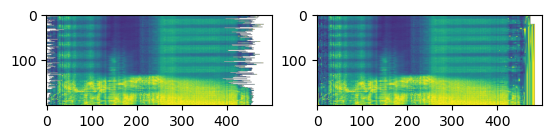

In [3]:
cutoff = 200

def ratio(i):
    stack = tif.imread(files[i])
    gfp, rfp = stack[:, 0], stack[:, 1]
    mask = (rfp >= cutoff)
    gfp[~mask] = 0
    rfp[~mask] = 0
    gfp_sum = np.sum(gfp, axis=(0, 1))
    rfp_sum = np.sum(rfp, axis=(0, 1))
    return gfp_sum / rfp_sum

ratios = [ratio(i) for i in range(len(files))]
ratios = np.stack(ratios, axis=0, dtype=np.float32)
ratios = (ratios / np.nanmax(ratios, axis=0))[:, ::-1]
ratios_interpolated = pd.DataFrame(ratios).interpolate(axis=0).values

plt.subplot(121)
plt.imshow(ratios)
plt.subplot(122)
plt.imshow(ratios_interpolated)

### Pick an area to fit

11 values interpolated


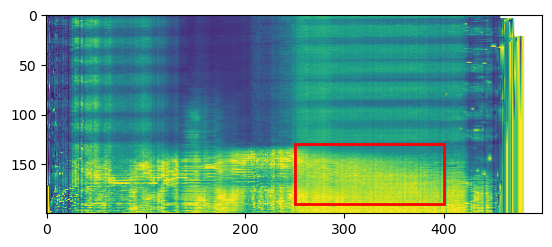

In [4]:
x, y, width, height = 250, 130, 150, 60
ax = plt.gca()
rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.imshow(ratios_interpolated)
rect = ratios[y:y+height, x:x+width]
rect_interpolated = ratios_interpolated[y:y+height, x:x+width]
print(f'{np.sum(np.isnan(rect))} values interpolated')

#### Fits the model, printed popt is [A, k, x0, t0]. Model is f = A * np.exp(-k * (X - x0) ** 2 / (T - t0))

R^2: 0.8840951614595104
[ 1.07810723e+00  1.79226026e-04 -1.54885880e+02 -5.87730693e+00]


/var/folders/11/rvdrcmxx2z7c2hsc_ly_6w_h0000gn/T/ipykernel_12650/3892788072.py:8: RuntimeWarning: overflow encountered in exp
  f = A * np.exp(-k * (X - x0) ** 2 / (T - t0))


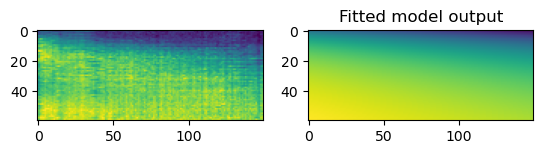

In [5]:
t = np.arange(rect_interpolated.shape[0]) * 0.533 # t in seconds
x = np.arange(rect_interpolated.shape[1]) * 0.36 # x in microns

T, X = np.meshgrid(t, x, indexing='ij')  # Ensure T.shape == norm_rect.shape

def model(coords, A, k, x0, t0):
    T, X = coords  # coords should be a tuple (T, X)
    f = A * np.exp(-k * (X - x0) ** 2 / (T - t0))
    return f.ravel()  # flatten to 1D for curve_fit

# Prepare input: curve_fit expects xdata (coords) and ydata as 1D arrays
coords = (T, X)
ydata = rect_interpolated.ravel()
popt, pcov = curve_fit(model, coords, ydata, p0=(1, 1e-6, -50, -10))

# Get fitted values from the optimized model
yfit = model(coords, *popt)

# Compute R-squared
ss_res = np.nansum((ydata - yfit) ** 2)
ss_tot = np.nansum((ydata - np.nanmean(ydata)) ** 2)
r_squared = 1 - ss_res / ss_tot

print("R^2:", r_squared)
print(popt)
# Now evaluate the fit model on the meshgrid and display with imshow
model_fit = model((T, X), *popt).reshape(T.shape)
plt.figure()
plt.subplot(121)
plt.imshow(rect_interpolated)
plt.subplot(122)
plt.imshow(model_fit)
plt.title("Fitted model output")
plt.show()

#### k is 1/4D so D is the following

In [6]:
0.25/popt[0]

np.float64(0.23188788106806976)

#### Fits at some spaced out columns

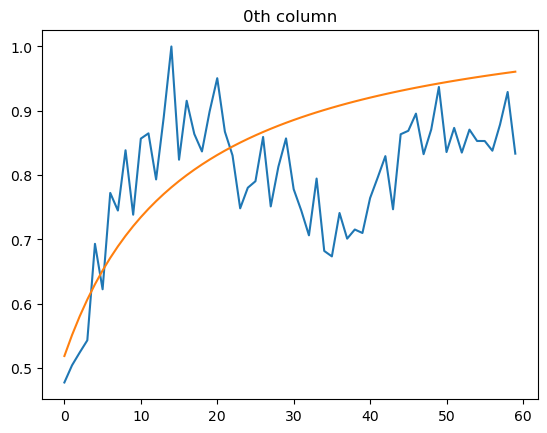

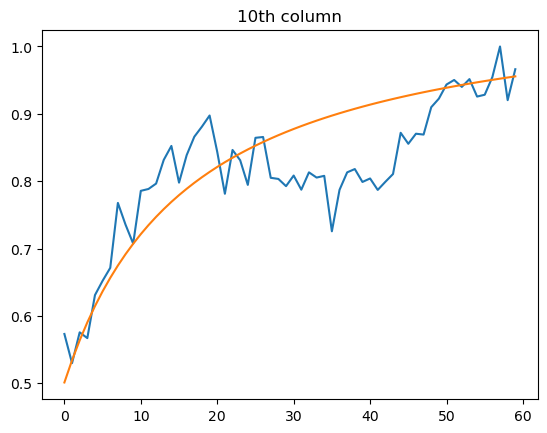

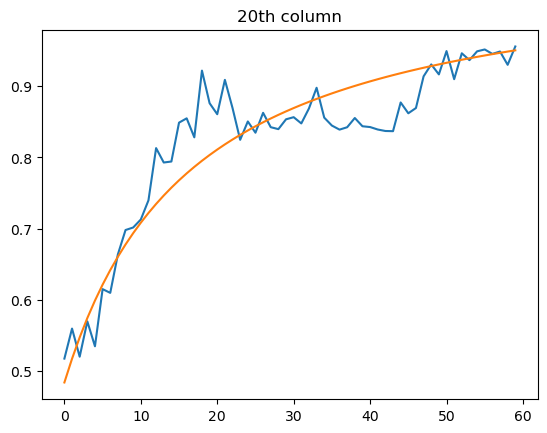

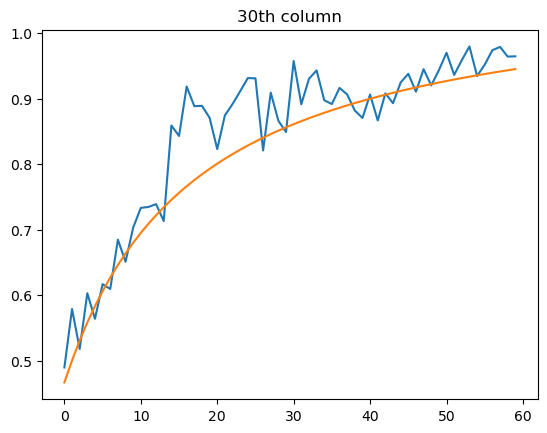

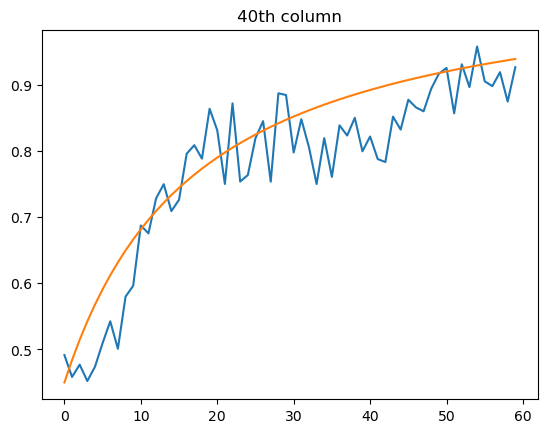

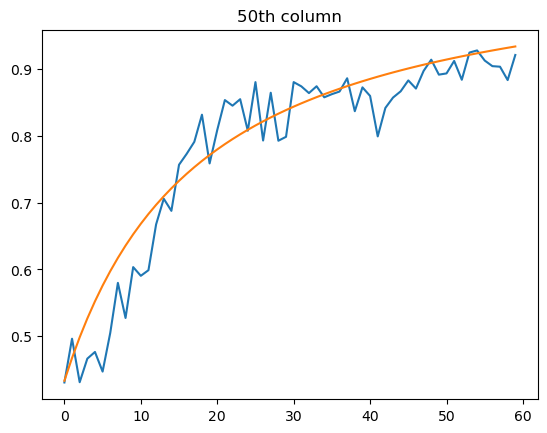

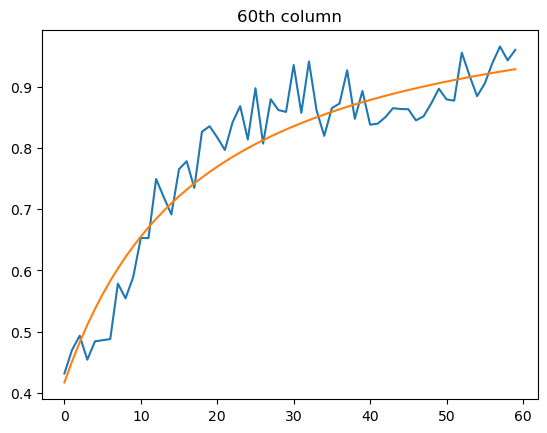

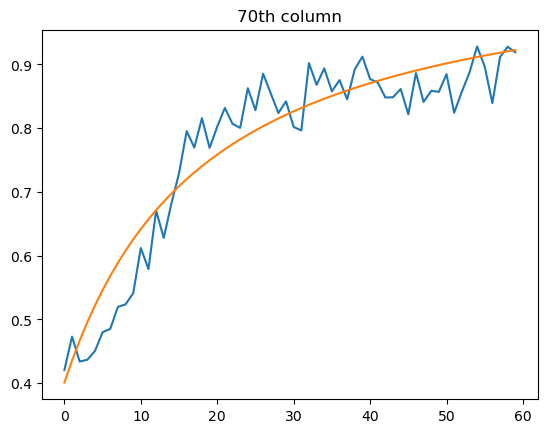

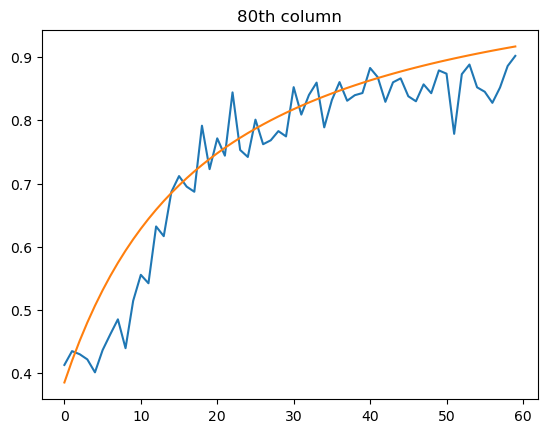

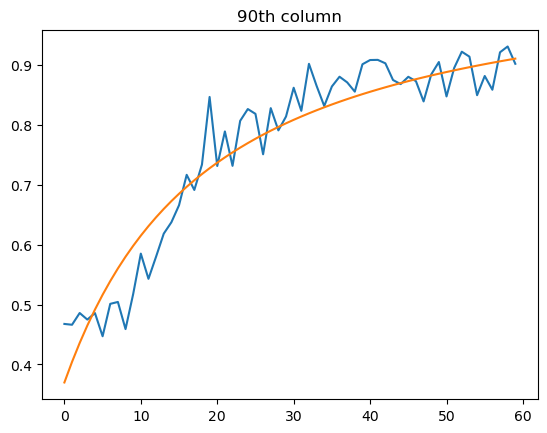

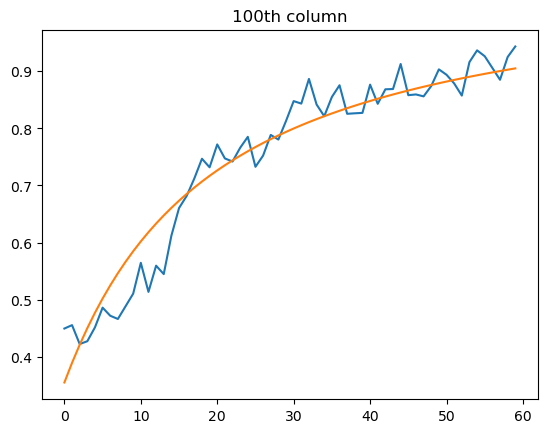

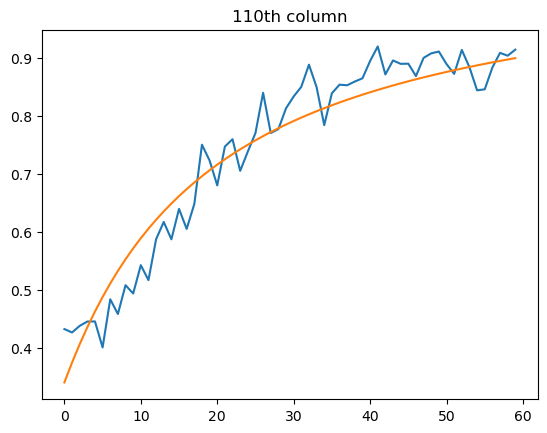

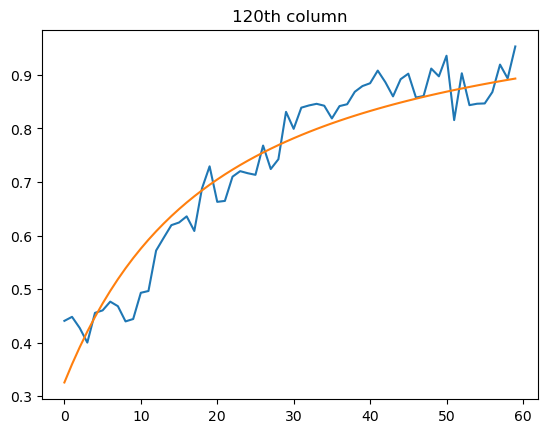

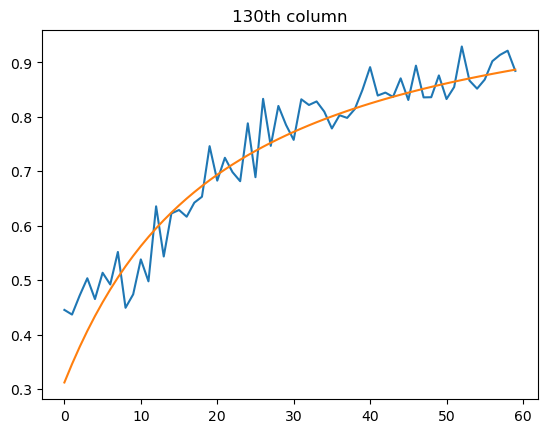

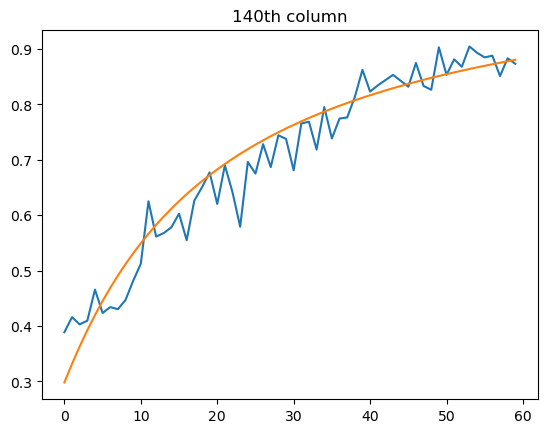

In [7]:
for i in range(0, rect_interpolated.shape[1], 10):
    plt.title(f'{i}th column')
    plt.plot(rect_interpolated[:, i])
    plt.plot(model_fit[:, i])
    plt.show()